# Rule-Based Techniques

Author: Alikhan Semembayev

## 1. Perform necessary data preprocessing, e.g. removing punctuation and stop words, stemming, lemmatizing, and replace sensitive information with a class tag. You may use the outputs from previous weekly assignments. (10 points)

In [5]:
from collections import defaultdict
import demoji
import svgling
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from autocorrect import Speller
import re

# Initialize tools
spell = Speller()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

email_re = r"\b[A-Za-z]+@\S+\b"
ssn_re = r"\b[0-9]{3}-[0-9]{2}-[0-9]{4}\b"
ip_re = r"\b\d{1,3}[.]\d{1,3}[.]\d{1,3}[.]\d{1,3}\b"

street_number_re = r"^\d{1,}"
street_name_re = r"[a-zA-Z0-9\s]+,?"
city_name_re = r" [a-zA-Z]+(\,)?"
state_abbrev_re = r" [A-Z]{2}"
postal_code_re = r" [0-9]{5}$"
address_pattern_re = r"" + street_number_re + street_name_re + city_name_re + state_abbrev_re + postal_code_re


def clean_text(text):
    # Replace emojis
    text = demoji.replace(text)

    # Remove smart quotes and dashes
    text = text.replace("“", "\"").replace("”", "\"").replace("-", " ").replace("'", " ")

    # Lowercase text
    text = text.lower()

    # Tokenize text
    words = word_tokenize(text)
    # print(words)

    # Spelling correction + replace all t with not
    words = ['not' if word == 't' else (
        'ADDRESS' if re.match(address_pattern_re, word)
        else (
            'EMAIL' if re.match(email_re, word)
            else (
                'SSN' if re.match(ssn_re, word)
                else (
                    'IP' if re.match(ip_re, word)
                    else spell(word)
                )
            )
        )
    ) for word in words]

    # Remove stop words and non-alphabetic tokens and punctuation
    words = [word for word in words if word.isalnum() and word not in stop_words or word in ['not', 'no']]

    # POS tagging and Lemmatization
    tagged_words = pos_tag(words)

    tag_map = defaultdict(lambda: "n")
    tag_map["N"] = "n"
    tag_map["V"] = "v"
    tag_map["J"] = "a"
    tag_map["R"] = "r"

    words = [lemmatizer.lemmatize(word, pos=tag_map[tag[0]]) for word, tag in tagged_words]

    # Return cleaned words as a single string
    return ' '.join(words)

In [6]:
import pandas as pd

data = (pd.read_csv('../../../../data/text/combined_raw.csv'))
data = data.dropna(how='any')

for row in data.values:
    row[0] = clean_text(row[0])

data.to_csv('../../../../data/text/combined_cleaned.csv', index=False)

print(data.head(10))

                                                text    emotion
0  freshwater fish drink water skin via osmosis s...      happy
1  think everyone must use daily become grained e...    neutral
2  agree google headquarters mountain view califo...    neutral
3  thats funny current ceo sunday ficha didnt kno...    neutral
4  oh yeah not know either also want go google al...  surprised
5                                                say  surprised
6        yeah apparently lol instead hire people row      happy
7  thats funny guess imaginative leave huge tech ...  surprised
8  yeah exactly sure cheap one thing bet not expl...  surprised
9  remember hearing immortality waste jellyfish h...    neutral


## 2. Generate additional training data for your project by substituting different words with the same superordinate term in different sentence patterns. (30 points)

In [20]:
import pandas as pd

data = (pd.read_csv('../../../../data/text/combined_cleaned.csv'))
data = data.dropna(how='any')

In [21]:
from nltk.corpus import wordnet


def get_superordinate(word):
    synsets = wordnet.synsets(word)
    if synsets:
        hypernyms = synsets[0].hypernyms()
        if hypernyms:
            return hypernyms[0].lemma_names()[0]
    return word


def generate_augmented_data(text):
    tokens = word_tokenize(text)
    augmented_tokens = [get_superordinate(word) for word in tokens]
    return " ".join(augmented_tokens)

data = data.head(100)
# Apply the function to generate new training data
data['text'] = data['text'].apply(generate_augmented_data)
data.to_csv('additional_data.csv', index=False)

print(data)

                                                 text    emotion
0   water aquatic_vertebrate helping liquid body_c...      happy
1   deliberation everyone necessity activity newsp...    neutral
2   agree google office natural_elevation orientat...    neutral
3   thats joke electrical_phenomenon corporate_exe...    neutral
4   oh yeah not knowing either also poverty shift ...  surprised
..                                                ...        ...
95  not deliberation achromatic_color taste aquati...  surprised
96  probably not domestic_animal locomotion advant...    neutral
97  digit shift knowing adapt organism create pers...    neutral
98  coldness conversation knowing 6331 abstraction...  surprised
99  deliberation sad relation animal right hyperse...        sad

[100 rows x 2 columns]


## 3. Perform context-free grammars and parsing on one of sentences in your project data.  (20 points)

In [73]:
import pandas as pd

data = (pd.read_csv('../../../../data/text/combined_raw.csv'))
data = data.dropna(how='any')

(S
  (NP (PRP i))
  (VP (V am) (Adv really) (Adj bad))
  (Conj but)
  (S (NP (PRP it)) (VP (V is) (NP (Det a) (Adj good) (N time)))))


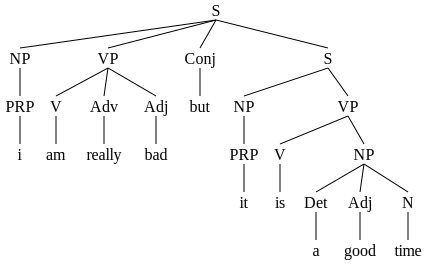

In [16]:
import nltk
from nltk import CFG
# "I am really bad, but it is a good time."
# Define the CFG
grammar = nltk.CFG.fromstring("""
  S -> NP VP Conj S | NP VP
  NP -> PRP | Det Adj N | PRP
  VP -> V Adv Adj | V NP | V Adj
  PRP -> 'i' | 'it'
  V -> 'am' | 'is'
  Adv -> 'really'
  Adj -> 'bad' | 'good'
  Det -> 'a'
  N -> 'time'
  Conj -> 'but'
""")

# Sentence to parse
sentence = nltk.tokenize.word_tokenize((data.values[20][0]).lower())
sentence = [word for word in sentence if word.isalnum()]

# Parser
parser = nltk.ChartParser(grammar)

# Parse
trees = list(parser.parse(sentence))
print(trees[0])
trees[0]

In [17]:
with open("parse_tree.txt", "w") as f:
    f.write(str(trees[0]))  # Write the parse tree as a string

## 4. Develop search criteria for your project and perform slot filling and slot visualization.  (40 points)

In [1]:
import pandas as pd

data = (pd.read_csv('../../../../data/text/combined_raw.csv'))
data = data.dropna(how='any')
data = data.head(100)

In [14]:
import spacy
from spacy.lang.en import English

nlp = English()

ruler = nlp.add_pipe("entity_ruler")
POLARITY_patterns = [
    {"label": "POLARITY", "pattern": "bad"},
    {"label": "POLARITY", "pattern": "good"},
    {"label": "POLARITY", "pattern": "nice"},
    {"label": "POLARITY", "pattern": "cool"},
    {"label": "POLARITY", "pattern": "great"},
    {"label": "POLARITY", "pattern": "funny"},
    {"label": "POLARITY", "pattern": "awful"},
    {"label": "POLARITY", "pattern": "fun"}]
SUBJECT_patterns = [
    {"label": "SUBJECT", "pattern": "i"},
    {"label": "SUBJECT", "pattern": "it"},
    {"label": "SUBJECT", "pattern": "you"}]
ACTION_patterns = [
    {"label": "ACTION", "pattern": "be"},
    {"label": "ACTION", "pattern": "am"},
    {"label": "ACTION", "pattern": "'m"},
    {"label": "ACTION", "pattern": "is"},
    {"label": "ACTION", "pattern": "'s"},
    {"label": "ACTION", "pattern": "'re"},
    {"label": "ACTION", "pattern": "are"}]
ADDITION_patterns = [
    {"label": "ADDITION", "pattern": "very"},
    {"label": "ADDITION", "pattern": "too"},
    {"label": "ADDITION", "pattern": "so"},
    {"label": "ADDITION", "pattern": "really"},
    {"label": "ADDITION", "pattern": "pretty"}]

ruler.add_patterns(POLARITY_patterns)
ruler.add_patterns(SUBJECT_patterns)
ruler.add_patterns(ACTION_patterns)
ruler.add_patterns(ADDITION_patterns)

arr = []

# Open file to write output
with open("slot_filling.txt", "w") as f:
    for row in data.values:
        doc = nlp(row[0])
        val = [(ent.text, ent.label_) for ent in doc.ents]
        arr.append(val)
        f.write(str(val) + "\n")  # Write each result to the file
        print(val)

[('are', 'ACTION')]
[('i', 'SUBJECT'), ('it', 'SUBJECT')]
[('is', 'ACTION')]
[('funny', 'POLARITY'), ('is', 'ACTION'), ('i', 'SUBJECT')]
[('it', 'SUBJECT')]
[]
[]
[('funny', 'POLARITY'), ('i', 'SUBJECT'), ('it', 'SUBJECT')]
[('am', 'ACTION'), ('are', 'ACTION'), ('is', 'ACTION'), ('are', 'ACTION'), ('so', 'ADDITION'), ('cool', 'POLARITY'), ('is', 'ACTION'), ('is', 'ACTION')]
[('i', 'SUBJECT'), ('is', 'ACTION'), ('you', 'SUBJECT'), ('is', 'ACTION')]
[('is', 'ACTION'), ('so', 'ADDITION'), ('funny', 'POLARITY'), ('it', 'SUBJECT'), ('is', 'ACTION'), ('so', 'ADDITION')]
[('i', 'SUBJECT')]
[]
[('i', 'SUBJECT')]
[('i', 'SUBJECT')]
[('be', 'ACTION'), ('fun', 'POLARITY'), ('so', 'ADDITION'), ('be', 'ACTION'), ('nice', 'POLARITY')]
[('i', 'SUBJECT')]
[('so', 'ADDITION'), ("'s", 'ACTION')]
[('you', 'SUBJECT')]
[('you', 'SUBJECT')]
[('am', 'ACTION'), ('really', 'ADDITION'), ('bad', 'POLARITY'), ('it', 'SUBJECT'), ('is', 'ACTION'), ('good', 'POLARITY')]
[('is', 'ACTION'), ('fun', 'POLARITY'), ('you'

In [15]:
from spacy import displacy

colors = {"POLARITY": "#ea7e7e",
          "SUBJECT": "#baffc9",
          "ACTION": "#abcdef",
          "ADDITION": "#ffffba"}
options = {"ents": ["POLARITY","SUBJECT","ACTION","ADDITION"], "colors": colors}

html_outputs = []

for row in data.values:
    doc = nlp(row[0])
    if doc.ents:
        html = displacy.render(doc, style="ent", options=options, page=False)
        html_outputs.append(html)